# Mts-MORF On Kuramoto Models

Kuramoto models are a popular model for coupled oscillators. They model oscillators' phases to bee dependent on the scaled phase differences between all pairs of oscillators. They are governed by an ordinary differential equation that couples based on the phase of each time series.

In [1]:
import pandas as pd
from scipy import stats
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
import seaborn as sns

import pickle
import time
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from rerf.rerfClassifier import rerfClassifier

import warnings
warnings.simplefilter('ignore')

In [2]:
from kuramoto import Kuramoto

In [49]:
def _sim_samples(T, clsid, dt):
    # Y0, W, K are initial phase, intrinsic freq and
    # coupling K matrix respectively
    Y0 = np.array([0, np.pi, 0])
    W = np.array([28, 19, 11])

    K1 = np.array([[0, 0.2,  1.1],
                   [0.5,   0, -0.7],
                   [0.3, 0.9,    0]])

    K2 = np.array([[0, 0.5, 1.0],
                   [0.4,    0, -1.0],
                   [ 0.3,  0.8,   0]])
    if clsid == 0:
        K = K2
    elif clsid == 1:
        K = K1
#     

    # Passing parameters as a dictionary
    init_params = {'W':W, 'K':K, 'Y0':Y0}

    # Running Kuramoto model
    kuramoto = Kuramoto(init_params)
    odePhi = kuramoto.solve(T)

    # Computing phase dynamics
    phaseDynamics = np.diff(odePhi)/dt
    
    # white noise
    white_noise = np.random.normal(0, 3, size=phaseDynamics.shape)
    
    return phaseDynamics + white_noise

In [50]:
T = np.arange(0, 4, 0.01)
x0 = _sim_samples(T, clsid=0, dt=0.01)
x1 = _sim_samples(T, clsid=1, dt=0.01)

print(x0.shape, x1.shape)

(3, 399) (3, 399)


(3, 2)


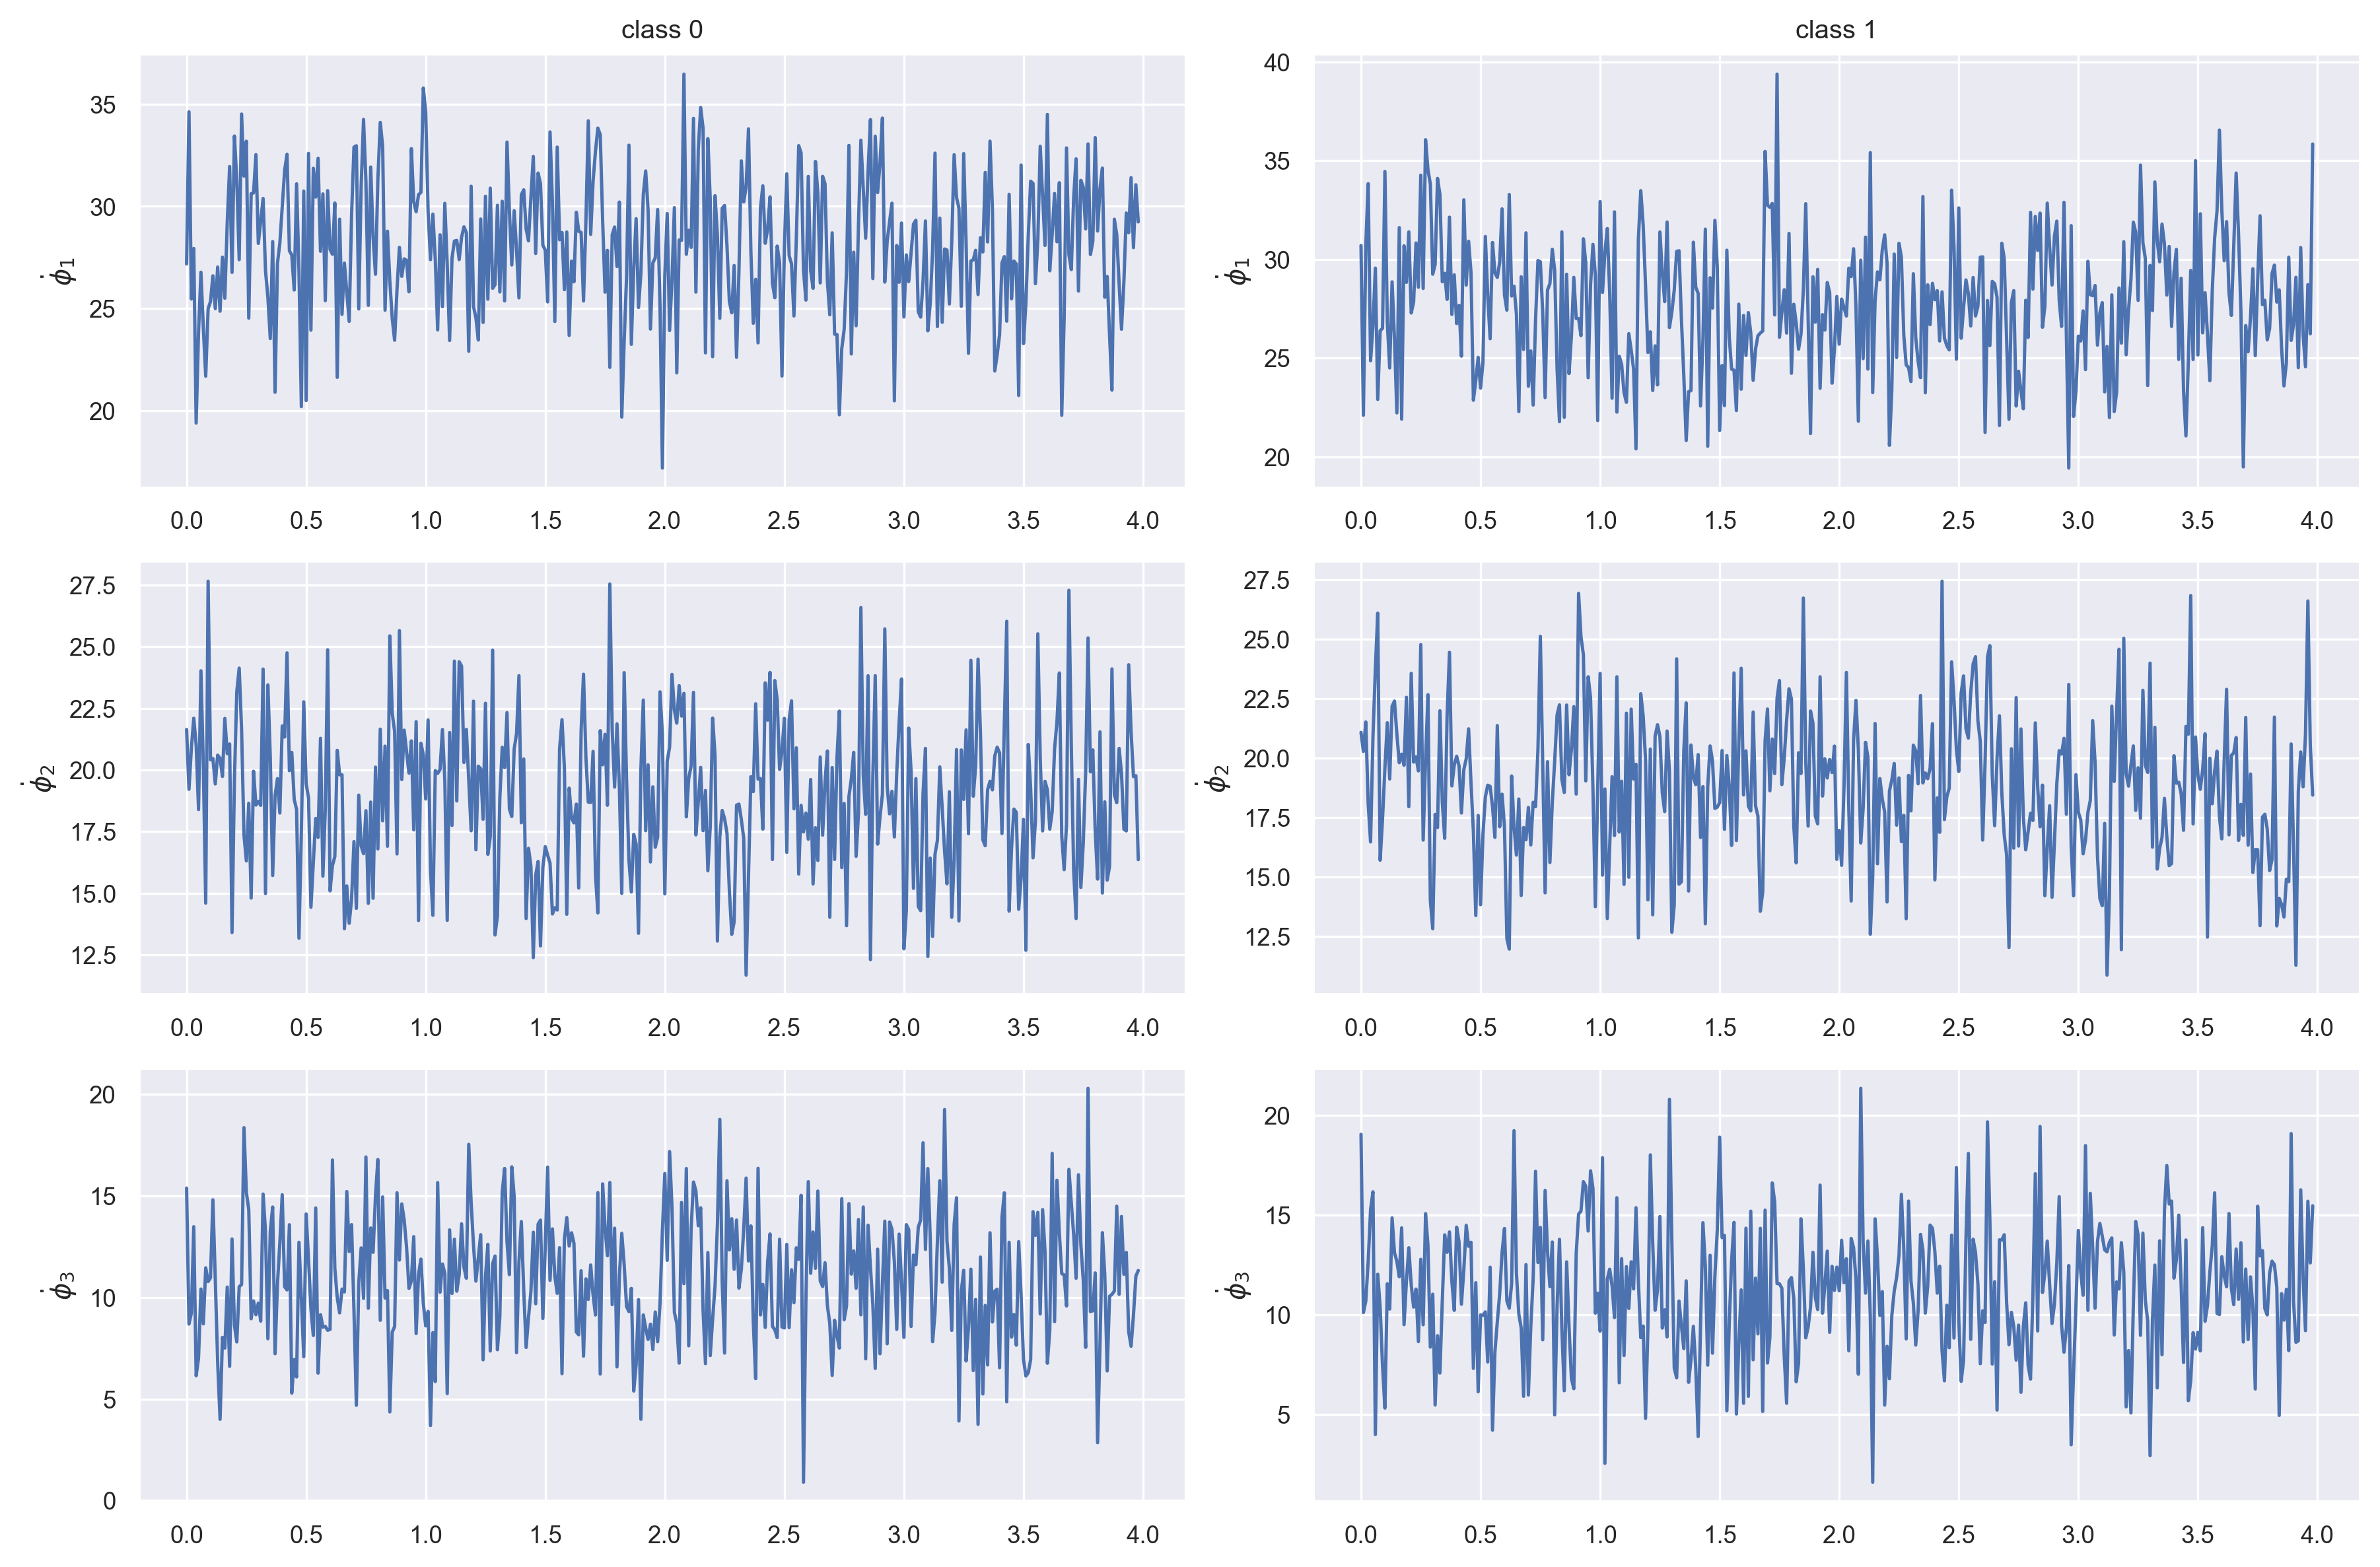

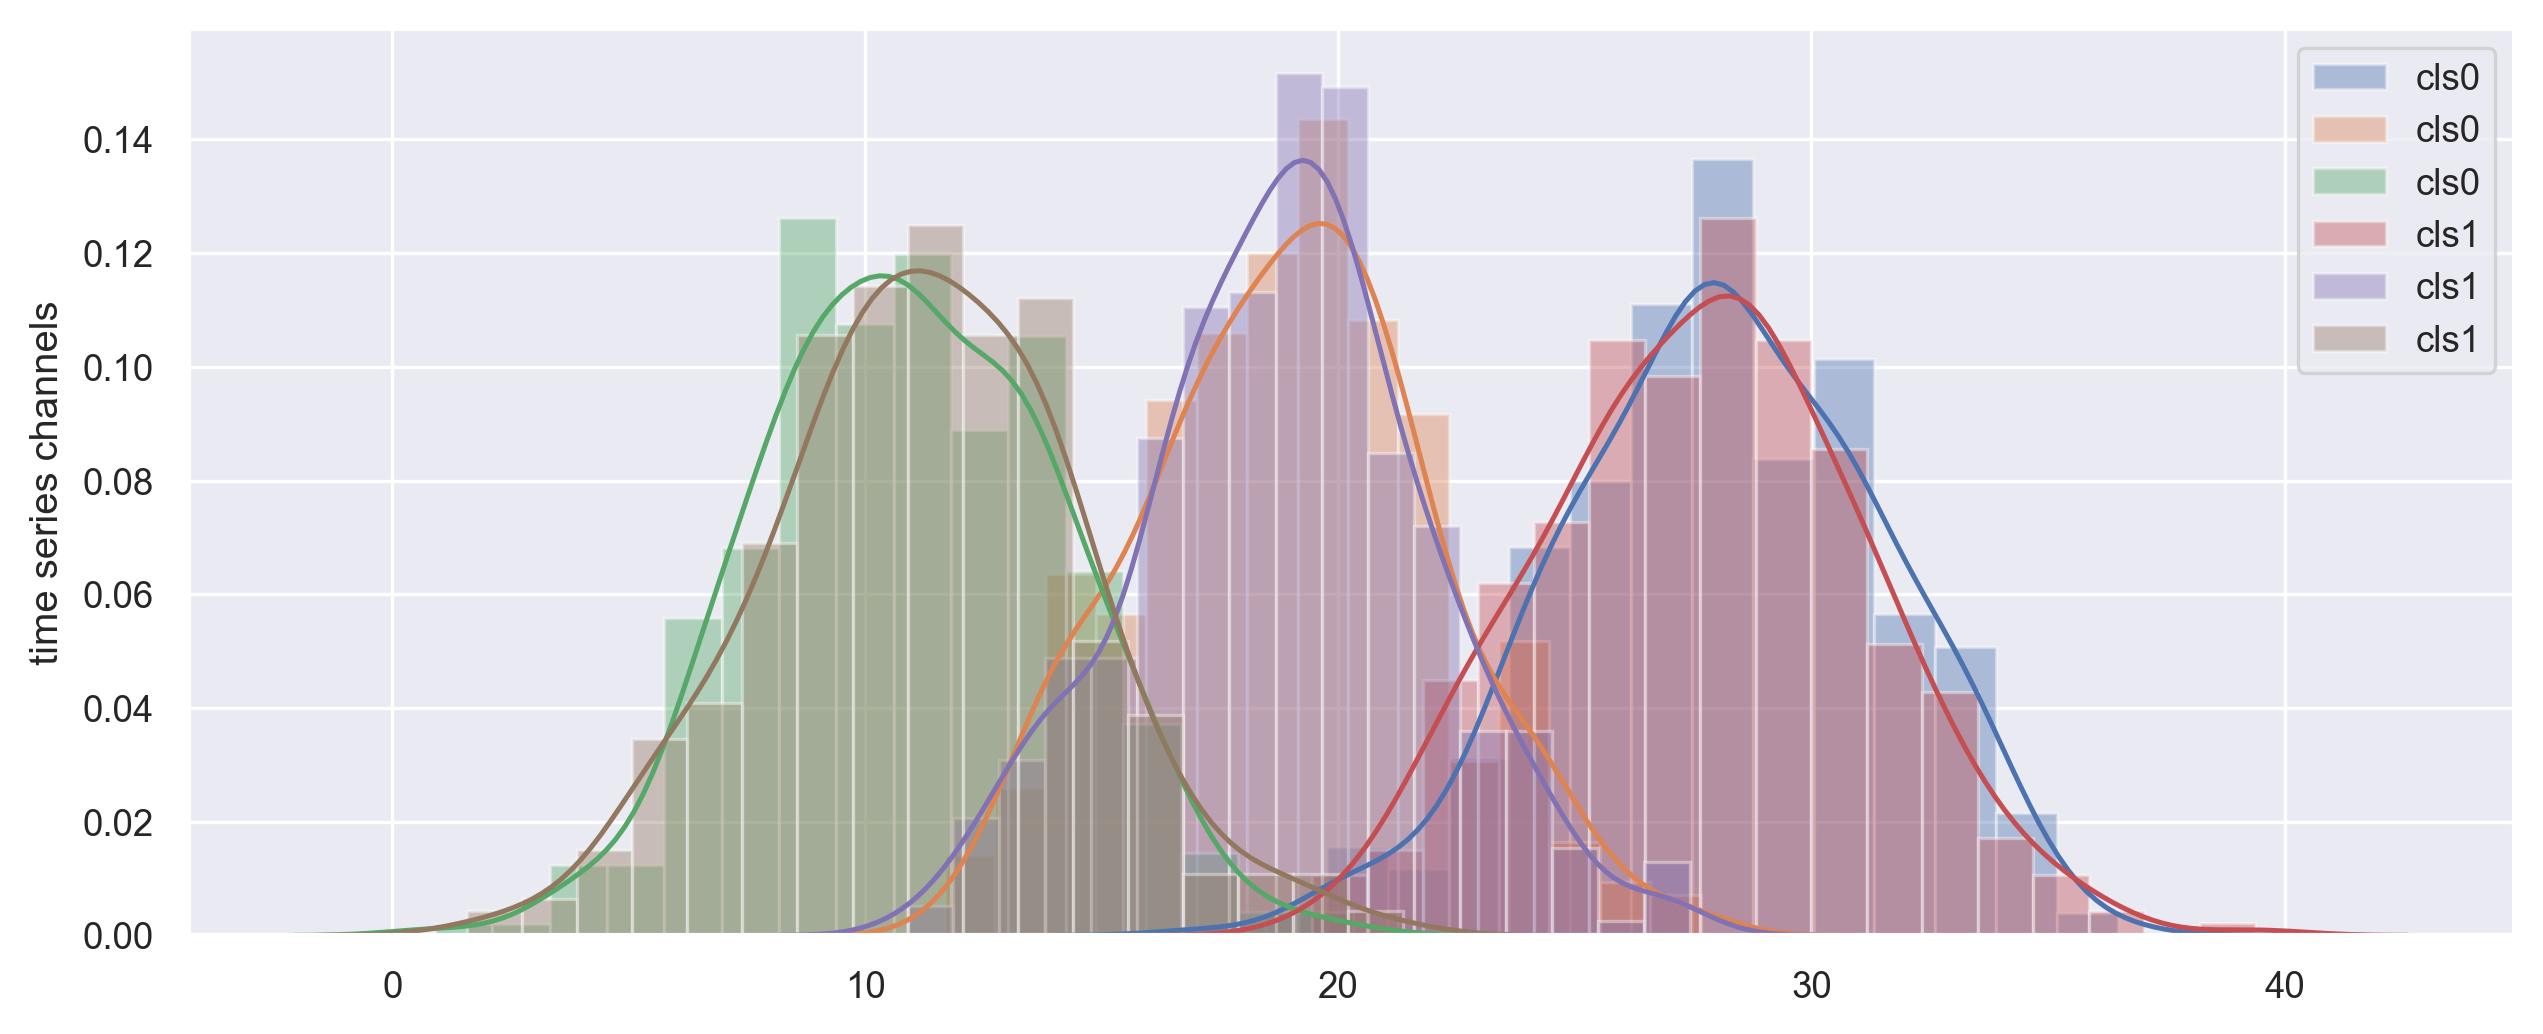

In [51]:
 # Plotting response
nOsc = x0.shape[0]
sns.set_context("paper")
fig, axs = plt.subplots(nOsc, 2)
print(axs.shape)
for i, phaseDynamics in enumerate([x0, x1]):
    for osc in range(nOsc):
        ax = axs[osc][i]
        ax.plot(T[:-1], phaseDynamics[osc])
        ax.set_ylabel("$\dot\phi_{%i}$" %(osc+1))
        if osc == 0:
            ax.set_title("class {}".format(i))
fig.tight_layout()
plt.show()

# Plot various projections of the samples.
fig, ax = plt.subplots(1,1,figsize=(10,4))
for i in range(3):
    sns.distplot(x0[i, :], ax=ax, label='cls0')
for i in range(3):
    sns.distplot(x1[i, :], ax=ax, label='cls1')
ax.set_ylabel('time series channels')
ax.legend()
# plt.axis('equal')
plt.grid(True)


In [52]:
np.random.seed(1234)

# length of data sequence
ns = np.array([
    50,100,
     150,
#                400,1000,2000
              ])
test_size = 0.5

# simulated data parameters
nchs = 3

# Defining time array
t0, t1, dt = 0, 40, 0.1
T = np.arange(t0, t1, dt)

# initialize data structures for train/test data
X_train, Y_train = np.empty(shape=(0, nchs, len(T)-1)), np.empty(shape=(0))
X_test, Y_test = np.empty(shape=(0,nchs,len(T)-1)), np.empty(shape=(0))

# simulate over varying sizes of data sequence
for n in ns:
    y = []
    X = []
    
    # generate correlated multi-variate time series
    for i in range(n):
        _x = _sim_samples(T, clsid=0, dt=0.01)
        X.append(_x)
        y.append(0)
    for i in range(n):
        _x = _sim_samples(T, clsid=1, dt=0.01)
        X.append(_x)
        y.append(1)
    X = np.array(X)
    y = np.array(y)
    
    print(X.shape, y.shape)
    # perform training test split
    _X_train, _X_test, _y_train, _y_test = train_test_split(X, y, 
                                                        test_size=test_size, random_state=42)
    print(_X_train.shape, _y_train.shape)
    X_train = np.vstack((X_train, _X_train))
    Y_train = np.hstack((Y_train, _y_train))
    X_test = np.vstack((X_test, _X_test))
    Y_test = np.hstack((Y_test, _y_test))

print(X_train.shape)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
print(X_train.shape, Y_train.shape, X_test.shape)

(100, 3, 399) (100,)
(50, 3, 399) (50,)
(200, 3, 399) (200,)
(100, 3, 399) (100,)
(300, 3, 399) (300,)
(150, 3, 399) (150,)
(300, 3, 399)
(300, 1197) (300,) (300, 1197)


# Initialize Classifier and Baseline Models

In [53]:
## Setup for run
names = {"Log. Reg": "blue", "Lin. SVM":"firebrick", "SVM":"purple",
          "kNN": "black", "RF":"#f86000", "MLP":"green", "S-RerF":"red", "MT-MORF": "orange"}

ncores=1
num_runs=1
n_est=100  # number of estimators

classifiers = [
    LogisticRegression(random_state=0, n_jobs=ncores, solver='liblinear'),
    LinearSVC(),
    SVC(C=1.0, kernel='rbf', gamma='auto',random_state=0),
    KNeighborsClassifier(3, n_jobs=ncores),
    RandomForestClassifier(n_estimators=n_est, max_features='auto', n_jobs=ncores),
    MLPClassifier(hidden_layer_sizes=(100, ), random_state=0, max_iter=1000),
    rerfClassifier(projection_matrix="S-RerF",
                   max_features='auto',
                   n_jobs=ncores,
                    n_estimators=n_est,
                    oob_score=False,
                    random_state=0,
                    image_height=nchs,
                    image_width=len(T)-1,
                    patch_height_max=3,
                    patch_height_min=1,
                    patch_width_max=20,
                    patch_width_min=2
                   ),
    rerfClassifier(projection_matrix="MT-MORF",
                   max_features='auto',
                   n_jobs=ncores,
                    n_estimators=n_est,
                    oob_score=False,
                    random_state=0,
                    image_height=nchs,
                    image_width=len(T)-1,
                    patch_height_max=3,
                    patch_height_min=1,
                    patch_width_max=20,
                    patch_width_min=2
                   )
    ]

# Run Classification Comparison Experiment

Perform a classification over all models, and then summarize in a figure

In [54]:
runList = [(n, clf, run) for n in ns\
                       for clf in zip(classifiers, [key for key in names])\
                       for run in range(num_runs)]
print("About to run", len(runList), "clf experiments")
print("Number of training samples per run: ", ns*test_size)

About to run 24 clf experiments
Number of training samples per run:  [25. 50. 75.]


In [55]:
# Train each classifier on each dataset size, then test
# Prep output file:
fname = './mt-morf_kuramoto_experiment.csv'
f = open(fname, 'w+')
f.write("classifier,n,Lhat,trainTime,testTime,iterate\n")
f.flush()

for n, clf, iteration in tqdm(runList):
    # print(clf)
    if X_train.ndim == 3:
        X_train = X_train.reshape(-1, X_train.shape[-1]).T
    if X_test.ndim == 3:
        X_test = X_test.reshape(-1, X_test.shape[-1]).T
    X = X_train[:n]
    y = Y_train[:n]

    trainStartTime = time.time()
    clf[0].fit(X, y)
    trainEndTime = time.time()
    trainTime = trainEndTime - trainStartTime

    testStartTime = time.time()
    out = clf[0].predict(X_test)
    testEndTime = time.time()
    testTime = testEndTime - testStartTime

    lhat = np.mean(np.not_equal(out, Y_test).astype(int))

    ####("variable,Lhat,trainTime,testTime,iterate")
    f.write(f"{clf[1]}, {n}, {lhat:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {iteration}\n")
    f.flush()

f.close()

100%|██████████| 24/24 [00:02<00:00, 11.01it/s]


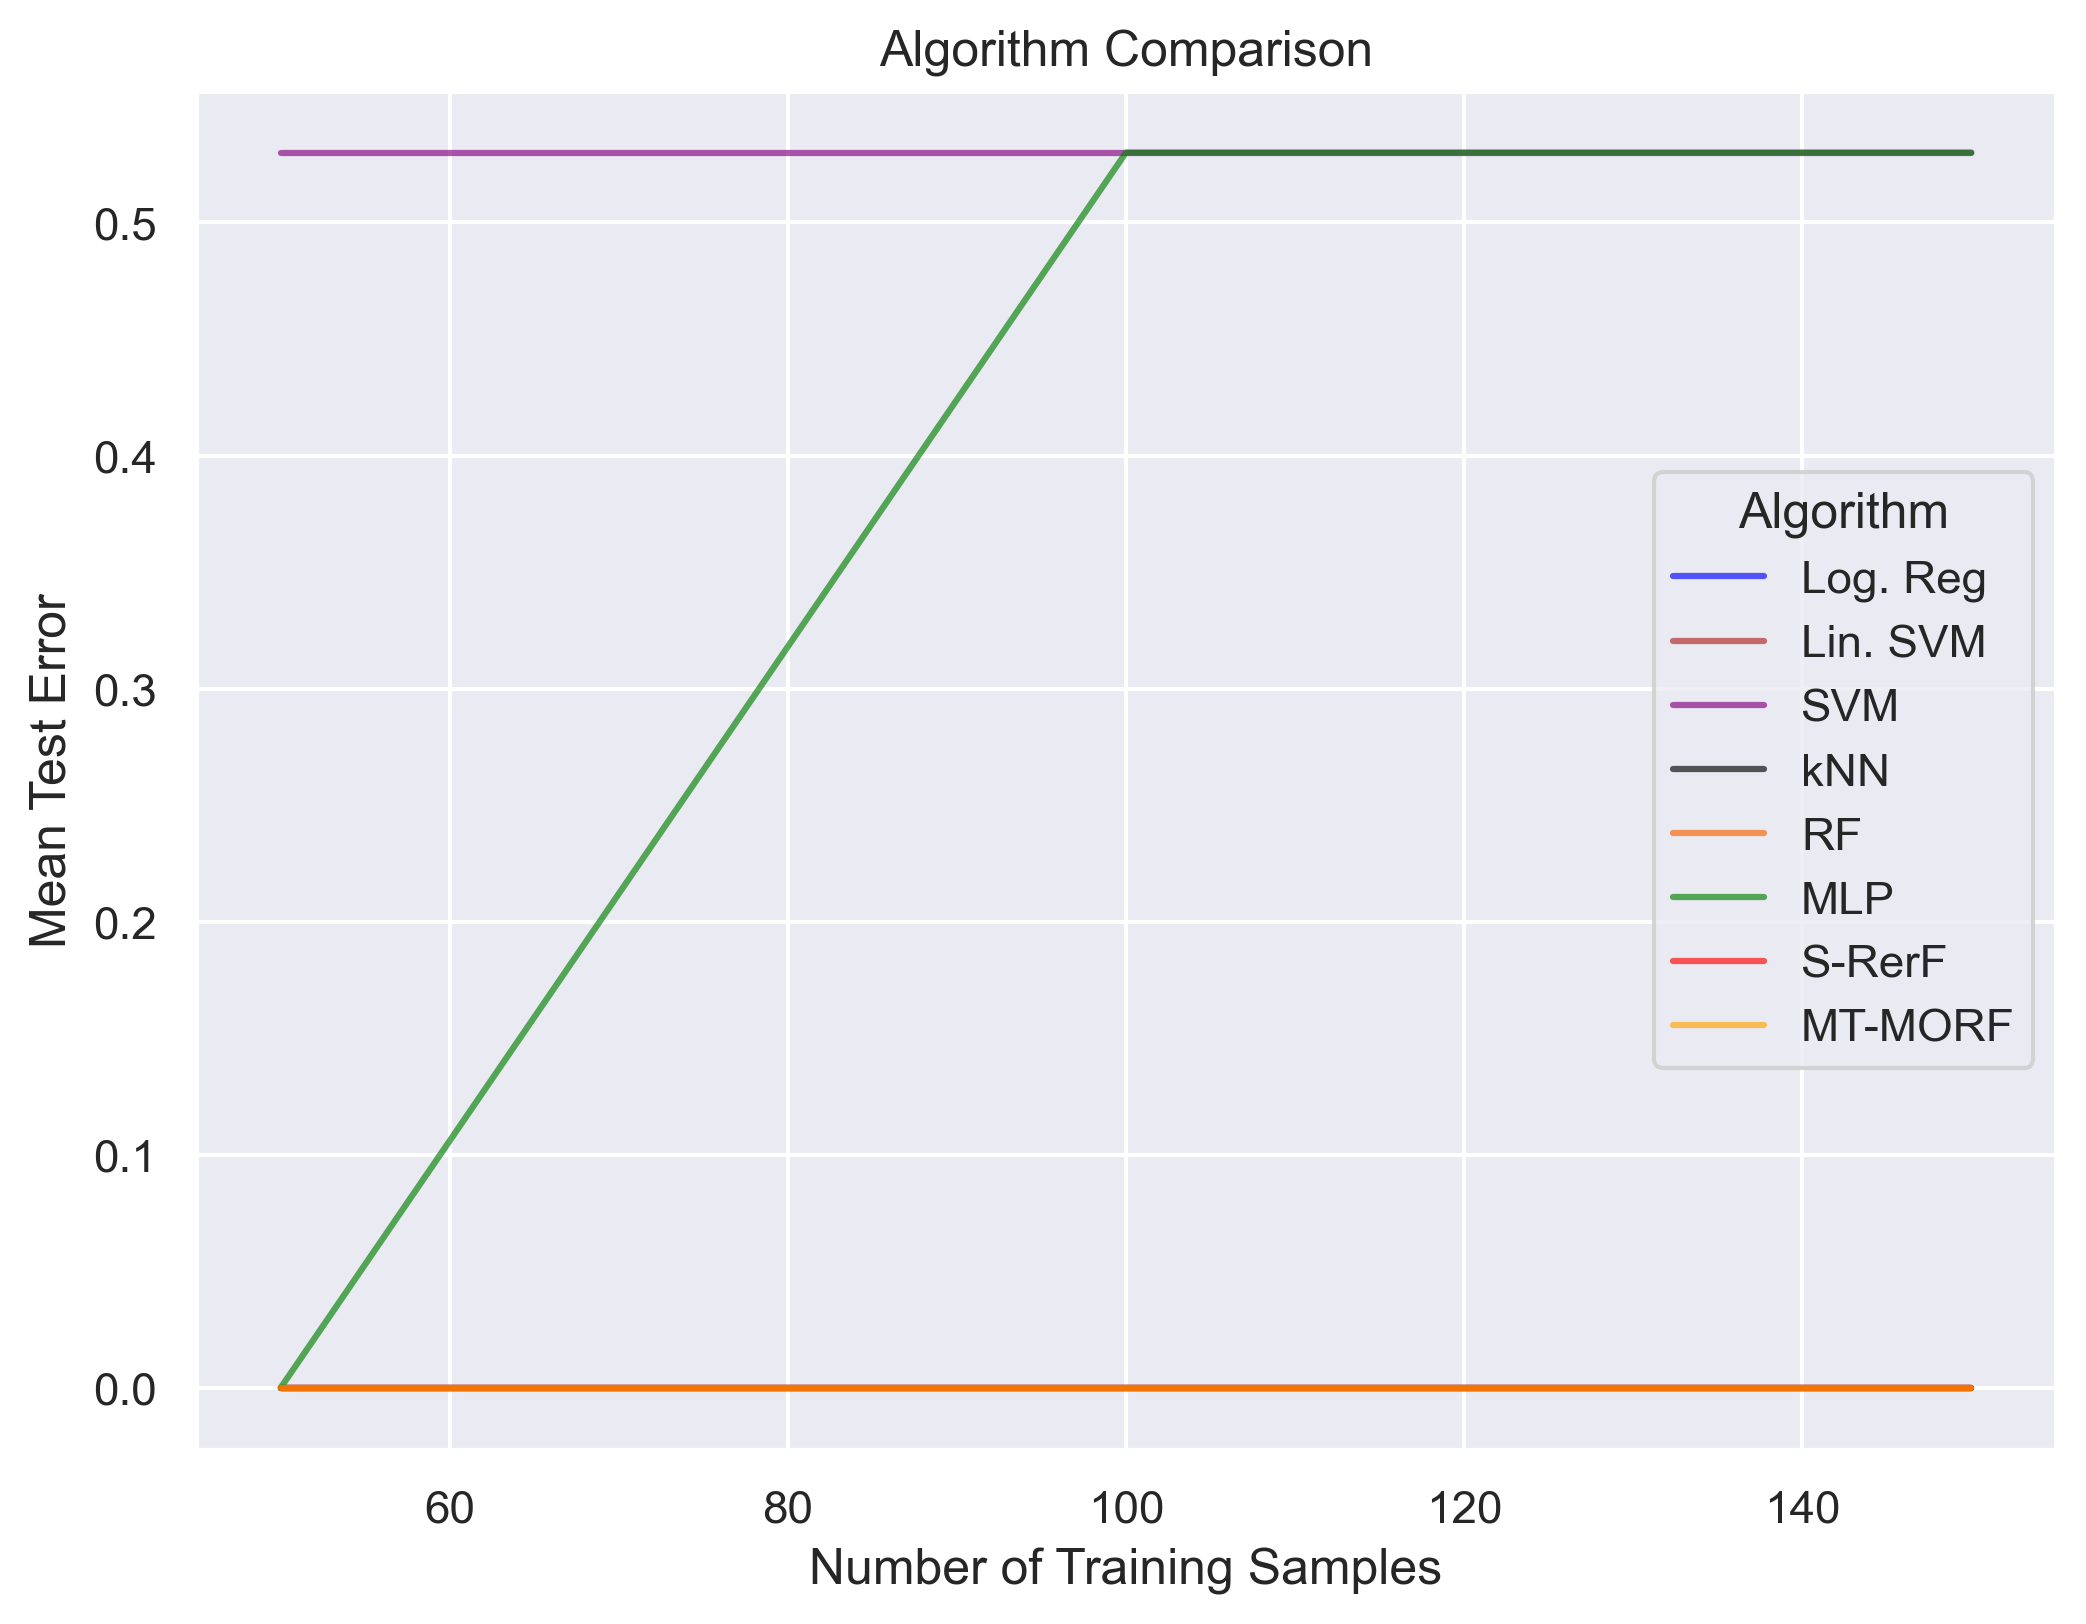

In [56]:
dat = pd.read_csv(fname)
d1 = pd.DataFrame(columns = ['classifier', 'n', 'Lhat', 'color'])

k = 0
for ni in np.unique(dat['n']):
    for cl in np.unique(dat['classifier']):
        tmp = dat[np.logical_and(dat['classifier'] == cl,dat['n'] == ni)][['n', 'Lhat']]
        d1.loc[k] = [cl] + list(tmp.mean()) + [names[cl]]
        k += 1


sns.set(style="darkgrid", rc={'figure.figsize':[12,8], 'figure.dpi': 300})
fig, ax = plt.subplots(figsize = (8,6))

for key in names.keys():
    grp = d1[d1['classifier'] == key]
    ax = grp.plot(ax=ax, kind='line', x='n', y='Lhat', label=key, \
            c = names[key], alpha =0.65)
    #ax.set_yscale('log')

plt.legend(loc='best',title='Algorithm')
plt.title('Algorithm Comparison')
plt.ylabel('Mean Test Error')
plt.xlabel('Number of Training Samples')
#plt.savefig('./s-rerf_impulse_experiment.pdf',dpi=300,format='pdf')
plt.show()